In [65]:
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import matplotlib.pyplot as plt
import cvxpy as cp
import random

In [77]:
upbr_series_code = 'UBPRE088'
ubpr_series_name = 'Efficiency Ratio'
ubpr_series_name_df = 'efficiency_ratio' # column name in the dataframe, no space
ffiec_form = 'FFIEC CDR UBPR Ratios Noninterest Income and Expenses'

In [78]:
# 1. LOAD AND CLEAN UBPR DATA
#    Adjust path/filename to match your file system
cnip_df = pd.read_csv(
    f'data/{ffiec_form} Combined.csv',
    index_col=0,
    header=[0,1]
)

In [79]:
# Convert the string index to datetime, then to date
cnip_df.index = pd.to_datetime(
    cnip_df.index,
    format="%m/%d/%Y %I:%M:%S %p"
)

# Drop the descriptive level from columns to make them easier to reference
cnip_df.columns = cnip_df.columns.droplevel(1)

In [80]:
def get_bank_groups(use_placebo=False, seed=42):
    """
    Returns treated and control bank groups - either original or shuffled for placebo tests.
    
    Parameters:
    -----------
    use_placebo : bool
        If True, returns shuffled bank groups for placebo tests
        If False, returns the original bank groups
    seed : int
        Random seed for reproducibility of shuffling
    
    Returns:
    --------
    tuple: (treated_group, control_group)
    """
    # Original bank groups
    original_treated = [
        3284070,  # Ally Financial Inc.
        1394676,  # American Express Company
        30810,    # Discover Financial Services
        723112,   # Fifth Third Bancorp
        12311,    # Huntington Bancshares Inc.
        280110,   # KeyCorp
        501105,   # M&T Bank Corporation
        233031    # Regions Financial Corporation
    ]
    
    original_control = [
        480228,   # Bank of America
        112837,   # Capital One
        476810,   # Citigroup
        852218,   # JPMorgan Chase
        210434,   # Northern Trust
        541101,   # Bank of New York Mellon
        2182786,  # Goldman Sachs
        817824,   # PNC
        504713,   # U.S. Bancorp
        451965    # Wells Fargo
    ]
    
    if not use_placebo:
        return original_treated, original_control
    
    # For placebo test, create combined list and randomly reassign
    random.seed(seed)
    all_banks = original_treated + original_control
    random.shuffle(all_banks)
    
    # Keep same group sizes, but with randomly assigned banks
    new_treated = all_banks[:len(original_treated)]
    new_control = all_banks[len(original_treated):]
    
    return new_treated, new_control

In [81]:
# 2. IDENTIFY TREATED vs. CONTROL BANKS
# Treated banks (removed from stress test in 2018)
treated_banks, control_banks = get_bank_groups(use_placebo=True)

start_date = pd.Timestamp('2012-09-30')
rollback_date = pd.Timestamp('2018-05-24')
dfast_2020 = pd.Timestamp('2019-12-31') # treated banks once again subject to stress test

subset_df = cnip_df[
    (cnip_df['ID RSSD'].isin(treated_banks + control_banks)) 
    & (cnip_df.index >= start_date)
    & (cnip_df.index <= dfast_2020)
].copy()

subset_df.rename(columns={'ID RSSD': 'bank_id', upbr_series_code: ubpr_series_name_df}, inplace=True)

# Build MultiIndex (bank_id, date)
subset_df['date'] = subset_df.index
subset_df.set_index(['bank_id', 'date'], inplace=True)

# Mark treated
subset_df['treated'] = np.where(
    subset_df.index.get_level_values('bank_id').isin(treated_banks), 
    1, 0
)

# Because index is date, compare to date
subset_df['post'] = (
    subset_df.index.get_level_values('date') >= rollback_date
).astype(int)

subset_df['treated_post'] = subset_df['treated'] * subset_df['post']

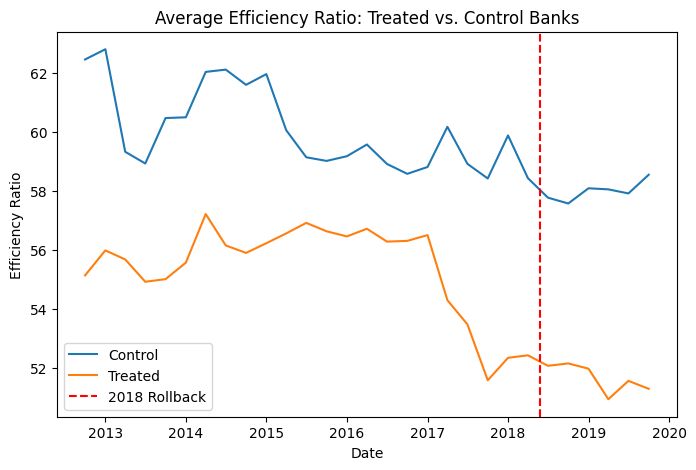

In [82]:
# 1. Convert MultiIndex -> standard DataFrame
df_plot = subset_df.reset_index()  # now have columns: bank_id, date, treated, tier1_leverage, etc.

# 2. Group by (date, treated) and compute average Tier 1 Leverage
trend_df = df_plot.groupby(['date','treated'], as_index=False)[ubpr_series_name_df].mean()

# 3. Plot treated vs. control over time
plt.figure(figsize=(8, 5))

for key, grp in trend_df.groupby('treated'):
    label = 'Treated' if key == 1 else 'Control'
    plt.plot(grp['date'], grp[ubpr_series_name_df], label=label)

# 4. (Optional) Add a vertical line for the policy date
policy_date = pd.Timestamp('2018-05-24')
plt.axvline(policy_date, color='red', linestyle='--', label='2018 Rollback')

plt.title(f"Average {ubpr_series_name}: Treated vs. Control Banks")
plt.xlabel("Date")
plt.ylabel(ubpr_series_name)
plt.legend()
plt.show()


In [83]:
# Run DiD
model = PanelOLS.from_formula(
    formula=f'{ubpr_series_name_df} ~ treated_post + EntityEffects + TimeEffects',
    data=subset_df
)
results = model.fit(cov_type='clustered', cluster_entity=True)
print(results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:       efficiency_ratio   R-squared:                        0.0078
Estimator:                   PanelOLS   R-squared (Between):             -0.0050
No. Observations:                 522   R-squared (Within):               0.0417
Date:                Wed, Apr 09 2025   R-squared (Overall):             -0.0047
Time:                        21:05:51   Log-likelihood                   -1438.0
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3.7269
Entities:                          18   P-value                           0.0541
Avg Obs:                       29.000   Distribution:                   F(1,475)
Min Obs:                       29.000                                           
Max Obs:                       29.000   F-statistic (robust):             0.3103
                            

### Synthetic DiD

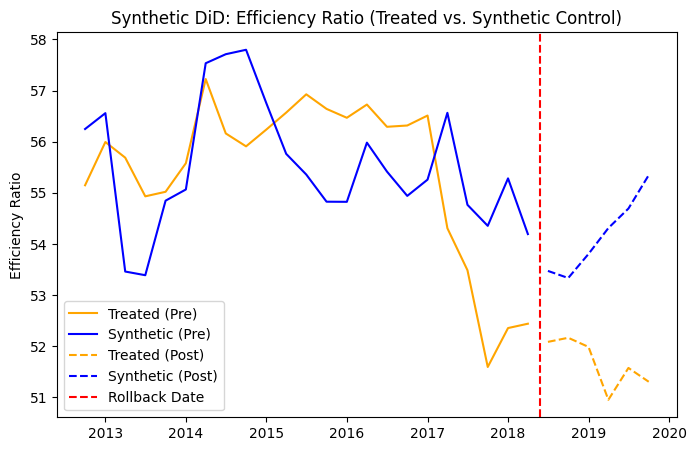

In [84]:
# 1. Split into PRE (post=0) and POST (post=1) periods
df_pre = subset_df[subset_df['post'] == 0].copy()
df_post = subset_df[subset_df['post'] == 1].copy()

# --------------------------------------------------------------------
# 2. Compute the average outcome for TREATED banks in the PRE period (by date)
treated_pre = df_pre[df_pre['treated'] == 1]
treated_pre_mean = treated_pre.groupby('date')[ubpr_series_name_df].mean()

# --------------------------------------------------------------------
# 3. Pivot the CONTROL banks' pre-period data into a (time x bank) matrix
#    so each column is the time series of a single control bank
control_pre = df_pre[df_pre['treated'] == 0].reset_index()
control_panel_pre = control_pre.pivot_table(
    index='date',
    columns='bank_id',
    values=ubpr_series_name_df
)

# Align the time index with the treated_pre_mean index (drop missing dates if necessary)
control_panel_pre = control_panel_pre.reindex(treated_pre_mean.index).dropna()

# --------------------------------------------------------------------
# 4. Solve a Quadratic Program to find weights that match the treated pre-trend
#    min_{w>=0, sum(w)=1}  sum( (treated_avg(t) - sum_j w_j * control_j(t))^2 )
n_controls = control_panel_pre.shape[1]

w = cp.Variable(n_controls, nonneg=True)
objective = cp.Minimize(
    cp.sum_squares(control_panel_pre.values @ w - treated_pre_mean[control_panel_pre.index].values)
)
constraints = [cp.sum(w) == 1]
problem = cp.Problem(objective, constraints)
problem.solve()  # Solve the QP

# Extract the control weights
w_opt = w.value  # array of shape (n_controls,)

# --------------------------------------------------------------------
# 5. Construct Synthetic Control in PRE and POST
#    (a) PRE: Using the same date index as control_panel_pre
syn_pre_vals = control_panel_pre.values @ w_opt  # Weighted combo of control banks in PRE
syn_pre_series = pd.Series(syn_pre_vals, index=control_panel_pre.index, name='synthetic_pre')

#    (b) POST: pivot the control banks in the post period
treated_post_mean = df_post[df_post['treated'] == 1].groupby('date')[ubpr_series_name_df].mean()
control_post = df_post[df_post['treated'] == 0].reset_index()
control_panel_post = control_post.pivot_table(
    index='date',
    columns='bank_id',
    values=ubpr_series_name_df
).reindex(treated_post_mean.index).dropna()

syn_post_vals = control_panel_post.values @ w_opt
syn_post_series = pd.Series(syn_post_vals, index=control_panel_post.index, name='synthetic_post')

# --------------------------------------------------------------------
# 6. Plot TREATED vs. SYNTHETIC in PRE & POST
plt.figure(figsize=(8,5))

# Pre
plt.plot(treated_pre_mean.index, treated_pre_mean, label='Treated (Pre)', color='orange')
plt.plot(syn_pre_series.index, syn_pre_series, label='Synthetic (Pre)', color='blue')

# Post
plt.plot(treated_post_mean.index, treated_post_mean, label='Treated (Post)', color='orange', linestyle='--')
plt.plot(syn_post_series.index, syn_post_series, label='Synthetic (Post)', color='blue', linestyle='--')

# Add a vertical line for the rollback date
rollback_date = pd.Timestamp('2018-05-24')
plt.axvline(rollback_date, color='red', linestyle='--', label='Rollback Date')

plt.title(f"Synthetic DiD: {ubpr_series_name} (Treated vs. Synthetic Control)")
plt.ylabel(ubpr_series_name)
plt.legend()
plt.show()

In [85]:
# --------------------------------------------------------------------
# PanelOLS to estimate the DiD effect
# Combine the pre and post to get full timeline for treated
treated_series = pd.concat([treated_pre_mean, treated_post_mean], axis=0).sort_index()
# And for synthetic
synthetic_series = pd.concat([syn_pre_series, syn_post_series], axis=0).sort_index()

In [86]:
df_sdid_list = []

# Treated group
df_treated = pd.DataFrame({
    'group_id': 1,
    'date': treated_series.index,
    'outcome': treated_series.values
})
df_sdid_list.append(df_treated)

# Synthetic group
df_synthetic = pd.DataFrame({
    'group_id': 0,
    'date': synthetic_series.index,
    'outcome': synthetic_series.values
})
df_sdid_list.append(df_synthetic)

# Combine and sort
df_sdid = pd.concat(df_sdid_list, ignore_index=True)
df_sdid = df_sdid.dropna(subset=['outcome']).sort_values(['group_id','date'])


In [87]:
df_sdid['treated'] = df_sdid['group_id']  # 1 for the actual treated group, 0 for synthetic
df_sdid['post'] = (df_sdid['date'] >= rollback_date).astype(int)
df_sdid['treated_post'] = df_sdid['treated'] * df_sdid['post']

In [88]:
df_sdid.set_index(['group_id','date'], inplace=True)

In [89]:
model = PanelOLS.from_formula(
    "outcome ~ treated_post + EntityEffects + TimeEffects",
    data=df_sdid
)

results = model.fit(cov_type='clustered', cluster_entity=True)
print(results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                outcome   R-squared:                        0.3026
Estimator:                   PanelOLS   R-squared (Between):             -0.0090
No. Observations:                  58   R-squared (Within):               0.3461
Date:                Wed, Apr 09 2025   R-squared (Overall):             -0.0086
Time:                        21:06:11   Log-likelihood                   -64.178
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      11.713
Entities:                           2   P-value                           0.0020
Avg Obs:                       29.000   Distribution:                    F(1,27)
Min Obs:                       29.000                                           
Max Obs:                       29.000   F-statistic (robust):          5.391e+30
                            